#### <h1 align=center><font size = 5>Capstone Project -18 : Crop Recommendation System</font></h1>
<h2 align=center><font size = 5>AIML Certification Programme</font></h2>

## Team <br>
1. Anuj Alex (2024AIML009)​
2. Gurbachan Singh Kalwan (2024AIML004)​
3. Krishna Murthy P (2024AIML078)​
4. Sidharth Gupta (2024AIML017)
5. Sree Rama Kumar Yeddanapudi (2024AILML008)​

Mentor: Prof. Aniruddha Dasgupta

In [1]:
import numpy as np # linear algebra
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import re
from rapidfuzz import process, fuzz

### 1. Loading and Reading Dataset

In [2]:
df = pd.read_csv("../data/AP_data.csv")
df.rename(columns={"Extent\n(AC)":"Farm_Acres","Crop before":"Crop_Sown"},inplace=True)
df['District'] = df['District'].replace({
    "Anantapur": "Ananthapur",
    "S.P.S.Nellore": "Nellore",
    "S.P.S. Nellore": "Nellore",
    "Kadapa YSR": "Kadapa"
})
df.head()

,Sl no,Date,Farmer No,Macro/ Micro nutrient,Farmer Name,District,Mandal,Village,Latitude,Longitude,...,Avail-Mg,Avail-S,Avail-Zn,Avail-B,Avail-Fe,Avail-Cu,Avail-Mn,Time,Season,Recommended Sowing Time
0,1.0,1/1/2015,1910,RK2276,P.Krishna Naik,Ananthapur,Penukonda,Gonipeta,14.08,77.69,...,101.0,5.16,0.30,0.17,8.89,0.51,15.24,1/1/2015,Kharif & Rabi,Kharif: June - July & Rabi: October - November
1,2.0,1/1/2015,1911,RK2277,Kallu Thippe Naik,Ananthapur,Penukonda,Gonipeta,14.09,77.69,...,261.0,9.91,0.36,0.57,3.24,0.44,6.90,1/1/2015,Kharif & Rabi,Kharif: June - July & Rabi: October - November
2,3.0,1/1/2015,1912,RK2278,P.Duble Bai,Ananthapur,Penukonda,Gonipeta,14.09,77.69,...,48.0,3.77,0.37,0.19,5.54,0.42,8.34,1/1/2015,Kharif & Rabi,Kharif: June - July & Rabi: October - November
3,4.0,1/1/2015,1913,RK2279,H.Marekka (Kamma),Ananthapur,Penukonda,Gonipeta,14.10,77.70,...,52.0,4.14,0.23,0.21,1.79,0.67,4.17,1/1/2015,Rabi,September - October
4,5.0,1/1/2015,1914,RK2280,M.Alevelamma,Ananthapur,Penukonda,Gonipeta,14.09,77.69,...,84.0,1.45,0.36,0.22,22.26,0.45,9.20,1/1/2015,Rabi,September - October


In [3]:
dist_master = pd.read_csv("../data/AP_district_level_master.csv")
dist_master.head()

,State,District,Soil_Percent,N_per_Ha,P_per_Ha,K_per_Ha,Kharif_rain,Rabi_rain,Zaid_rain,Area,Rank,Stand_Soil,Stand_Crop
0,Andhra Pradesh,Ananthapur,100,27.71,17.96,6.99,272,148,77,594.740,1.0,Sandy,['Groundnut']
1,Andhra Pradesh,Ananthapur,100,27.71,17.96,6.99,272,148,77,586.860,2.0,Sandy,['Other']
2,Andhra Pradesh,Ananthapur,100,27.71,17.96,6.99,272,148,77,51.825,3.0,Sandy,['Rice']
3,Andhra Pradesh,Ananthapur,100,27.71,17.96,6.99,272,148,77,43.055,4.0,Sandy,['Other']
4,Andhra Pradesh,Ananthapur,100,27.71,17.96,6.99,272,148,77,24.800,5.0,Sandy,['Pigeonpea']


### 1.1 Merge datasets

In [4]:
# Merge the DataFrames using left_on and right_on
rain_df= dist_master[["District","Kharif_rain",	"Rabi_rain",	"Zaid_rain"]].drop_duplicates()
# print(rain_df.head())
merged_df = pd.merge(df,rain_df, left_on='District', right_on='District',how='left')

### 1.2 Remove unnecessary columns

In [5]:
merged_df.drop(columns=["Sl no", "Date", "Farmer No", "Macro/ Micro nutrient", "Farmer Name", "Fathers Name", "Time"
                        , "Recommended Sowing Time", "Season", "Farm_Acres", "Survey No.","Latitude","Longitude"], inplace=True)

In [6]:
orig_df = df
df = merged_df

### 1.3 Check basic data statistics (shape, info, describe)

In [7]:
df.shape

(4816, 21)

In [8]:
df.describe()

,pH,EC,Avail-P,Exch-K,Avail-Ca,Avail-Mg,Avail-Zn,Avail-Fe,Avail-Cu,Avail-Mn,Kharif_rain,Rabi_rain,Zaid_rain
count,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000
mean,7.477844,0.489531,16.704285,159.676012,2416.086604,522.878920,1.111973,28.349657,2.533325,18.805155,503.790447,311.759917,74.812461
std,1.052134,1.045581,18.810818,135.616280,2155.234533,473.764527,1.396243,38.578050,3.061383,18.965475,169.263499,151.074131,19.353745
min,4.150000,0.010000,0.450000,12.000000,20.000000,2.000000,0.030000,0.040000,0.030000,0.010000,272.000000,125.000000,49.000000
25%,6.740000,0.110000,5.160000,82.000000,839.000000,184.000000,0.410000,5.780000,0.930000,8.100000,404.000000,235.000000,55.000000
50%,7.810000,0.220000,10.930000,129.000000,1652.000000,374.000000,0.700000,12.210000,1.460000,12.960000,455.000000,270.000000,70.000000
75%,8.270000,0.510000,21.410000,196.000000,3150.500000,715.500000,1.250000,33.980000,2.600000,22.125000,699.000000,375.000000,94.000000
max,9.890000,27.500000,361.940000,2409.000000,13304.000000,5363.000000,23.920000,354.700000,20.180000,256.880000,806.000000,710.000000,109.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4816 entries, 0 to 4815
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   District     4815 non-null   object 
 1   Mandal       4815 non-null   object 
 2   Village      4815 non-null   object 
 3   Soil type    4749 non-null   object 
 4   Crop_Sown    4595 non-null   object 
 5   pH           4815 non-null   float64
 6   EC           4815 non-null   float64
 7   OC           4815 non-null   object 
 8   Avail-P      4815 non-null   float64
 9   Exch-K       4815 non-null   float64
 10  Avail-Ca     4815 non-null   float64
 11  Avail-Mg     4815 non-null   float64
 12  Avail-S      4815 non-null   object 
 13  Avail-Zn     4815 non-null   float64
 14  Avail-B      4815 non-null   object 
 15  Avail-Fe     4815 non-null   float64
 16  Avail-Cu     4815 non-null   float64
 17  Avail-Mn     4815 non-null   float64
 18  Kharif_rain  4815 non-null   float64
 19  Rabi_r

In [10]:
cols_to_convert = ['OC', 'Avail-S', 'Avail-B']
for col in cols_to_convert:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

### 1.4 Display unique and sample values for columns

In [11]:
for col in df.columns:
    print(col, df[col].nunique(),df[col].unique()[0:20],'\n')

District 13 ['Ananthapur' 'Chittoor' 'East Godavari' 'Guntur' 'Kadapa' 'Krishna'
 'Kurnool' 'Nellore' 'Prakasam' 'Srikakulam' 'Visakhapatnam'
 'Vizianagaram' 'West Godavari' nan] 

Mandal 31 ['Penukonda' 'Raptadu' 'Santipuram' 'V.Kota' 'Gangavaram' 'Kollur'
 'Sattenapalli' 'B Mattam' 'Porumamilla' 'Sambepalli' 'Veeraballi'
 'G Konduru' 'Ghantasala' 'Banaganpalli' 'Devanakonda' 'Indukurpeta'
 'Podalakuru' 'T.P.Gudur' 'Kanigiri' 'Konakana Mitta'] 

Village 251 ['Gonipeta' 'Kondampalli' 'Settipalli' 'G.Koythapally' 'Gandlaparthi'
 'Gollapalli' 'Palbhavi' 'Pesarakunta' 'Pullalarevu' 'Raminepally'
 '121.Pedduru' '30.Sonneganipalle' 'Bellakogilla' 'Bendamakuppam'
 'Chinnaridoddi' 'Dandikuppam' 'Kadapalle' 'Kenumakulapalle'
 'Konerukuppam' 'Settiballa'] 

Soil type 99 ['Mixed soil' 'Redsoil' 'Sandi soil' 'Red soil' 'Black Soil' 'Sandy soil'
 'RED' 'BLACK' nan 'SAND' 'Red' 'Black' 'red' 'Rock soil' '-' 'Sandy Red'
 'Red Sandy' 'Sandy' 'Black Sandy' 'Claim'] 

Crop_Sown 129 ['Ground Nut' 'Horse

### 2. Data Preprocessing

### 2.1 Check for Data Quality Issues

* duplicate data
* missing data
* data inconsistencies

In [12]:
# duplicate data
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 1


In [13]:
# missing data
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]
print(missing_data.sort_values(ascending = False))

Crop_Sown      221
Soil type       67
OC               3
Avail-S          2
Avail-B          2
District         1
Rabi_rain        1
Kharif_rain      1
Avail-Mn         1
Avail-Cu         1
Avail-Fe         1
Avail-Zn         1
Avail-Ca         1
Avail-Mg         1
Mandal           1
Exch-K           1
Avail-P          1
EC               1
pH               1
Village          1
Zaid_rain        1
dtype: int64


### 2.2 Handle missing values for numerical attributes

In [14]:
numerical_cols = df.select_dtypes(include=['float64','int64']).columns

In [15]:
numerical_cols

Index(['pH', 'EC', 'OC', 'Avail-P', 'Exch-K', 'Avail-Ca', 'Avail-Mg',
       'Avail-S', 'Avail-Zn', 'Avail-B', 'Avail-Fe', 'Avail-Cu', 'Avail-Mn',
       'Kharif_rain', 'Rabi_rain', 'Zaid_rain'],
      dtype='object')

In [16]:
for col in numerical_cols:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)

In [17]:
# missing data
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]
print(missing_data.sort_values(ascending = False))

Crop_Sown    221
Soil type     67
District       1
Mandal         1
Village        1
dtype: int64


In [18]:
# import re
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from rapidfuzz import process, fuzz
# from sklearn.preprocessing import LabelEncoder

### 2.3 Handle missing values for Soil

In [19]:
# --- Master Soil categories ---
master_categories = [
    "Black", "Red", "Sandy", "Loam", "Clay",
    "Brown", "Yellow", "White", "Laterite",
    "Saline", "Alkaline", "Alluvial",
    "Gravel/Stony", "Mixed", "Other"
]

# --- Known corrections / synonyms ---
direct_map = {
    # Misspellings
    "RED": "Red",
    "red": "Red",
    "Red soil": "Red",
    "res": "Red",
    "redsoil": "Red",
    "redsoils": "Red",
    "red sandy loam": "Red",
    "red sandy": "Red",
    "red sandy\\": "Red",
    "redsandy": "Red",
    "redsandylo": "Red",
    "redsand": "Red",
    "redloam": "Red",
    "redbrown": "Red",
    "red grey": "Red",
    "red masari": "Red",

    "black soil": "Black",
    "Black Soil": "Black",
    "BLACK": "Black",
    "black clay": "Black",
    "black sandy": "Black",
    "black sandy loam": "Black",
    "black loam": "Black",
    "deepblack": "Black",
    "deep black": "Black",
    "normal bla": "Black",
    "black mix": "Black",
    "black mara": "Black",


    "sandi": "Sandy",
    "sanday": "Sandy",
    "sanday+bla": "Sandy",
    "sanday mix": "Sandy",
    "sand mixed": "Sandy",
    "sand mix": "Sandy",
    "sandy loam": "Sandy",
    "sandy mixe": "Sandy",
    "sandy with": "Sandy",
    "sandy brow": "Sandy",
    "sandy whit": "Sandy",


    "clayey loam": "Clay",
    "clay soil": "Clay",
    "caly soil": "Clay",
    "clay-sandy": "Clay",
    "silty clay": "Clay",

    "broan clay": "Brown",
    "brown light": "Brown",
    "brown dark": "Brown",
    "light brow": "Brown",
    "dark brown": "Brown",

    "alkhaline": "Alkaline",
    "alkline": "Alkaline",
    "alkline +": "Alkaline",
    "black alka": "Alkaline",

    "saline soi": "Saline",
    "salain": "Saline",
    "salty": "Saline",
    "salain mix": "Saline",
    "saline mix": "Saline",

    "laterite s": "Laterite",
    "laterite l": "Laterite",
    "laterite m": "Laterite",
    "laterite u": "Laterite",
    "latritate": "Laterite",
    "red lateri": "Laterite",

    "loamy soil": "Loam",
    "loomy": "Loam",
    "loami": "Loam",
    "laomy": "Loam",
    "soil loamy": "Loam",
    "loamy brow": "Loam",
    "ORTHIDS": "Loam",

    "white gara": "White",
    "white mixe": "White",
    "white soil": "White",
    "whitebrown": "White",
    "white sand": "White",
    "white red": "White",
    "white yell": "White",
    "brown whit": "White",

    "yellowblac": "Yellow",
    "yellowbrow": "Yellow",
    "yellow red": "Yellow",
    "white yello": "Yellow",

    # Loam/Alluvial
    "alluvial s": "Alluvial",
}
direct_map.update({
    # Sandy soils
    "SANDY ALFISOL": "Sandy",
    "SANDY ALFISOLS": "Sandy",
    "PSSAMENTS": "Sandy",
    "PSSAMNETS": "Sandy",
    "INNCEPTISOLS": "Sandy",
    "INSEPTISOLS": "Sandy",

    # Loam soils / Alfisols / Inceptisols variants
    "ORTHIDS": "Loam",
    "LOAMY ALFISOLS": "Loam",
    "LOAMY ALFISOL": "Loam",
    "USTALF/USTOLLS": "Loam",
    "UDUPTS/UDALFS": "Loam",
    "UDOLLS/UDALFS": "Loam",
    "INCEPTISOLS": "Loam",

    # Black soils / Vertisols variants
    "VERTISOLS": "Black",
    "VERTIC SOILS": "Black",
    "VERTIC SOLS": "Black",
    "VERTI SOLS": "Black",
    "VRTIC SOILS": "Black",
    "VERRTISOLS": "Black",
    "VERTIC OSILS": "Black",
})
# --- Local overrides (dialect → base class) ---
overrides = {
    "chowdu": "Red",
    "nalla regadi": "Red",
    "regadi": "Red",
    "sowdu": "Red",
    "sudda": "Red",
    "thella kattu": "Red",
    "sudda neela": "Red",
    "tella masaka": "Red",
    "erra maska": "Red",
    "savudu": "Red",
    "garuku": "Other",
    "garasu": "Red",
    "garasu mix": "Red",
    "garsu mix": "Red",
    "mosari": "Red",
    "masari": "Red",
    "masali": "Red",
    "masale": "Red",
    "masori": "Red",
    "madikattu": "Red",
    "maradi": "Red",
    "marad": "Red",
    "mardi": "Red",
    "marali": "Red",
    "moram": "Red",
    "maralugodu": "Red",

    "murrum": "Black",
    "murum soil": "Black",
    "medium bla": "Black",
    "m black": "Black",
    "black muri": "Black",
    "humpli bla": "Black",

    "kari": "Black",
    "kapu": "Black",
    "kappu": "Black",

    "kemp": "Red",
    "kempu": "Red",
    "k-r": "Red",
    "r-k": "Red",
    "r-m": "Red",
    "m-r": "Red",
}

In [20]:
print(master_categories)

['Black', 'Red', 'Sandy', 'Loam', 'Clay', 'Brown', 'Yellow', 'White', 'Laterite', 'Saline', 'Alkaline', 'Alluvial', 'Gravel/Stony', 'Mixed', 'Other']


In [21]:
print(direct_map)

{'RED': 'Red', 'red': 'Red', 'Red soil': 'Red', 'res': 'Red', 'redsoil': 'Red', 'redsoils': 'Red', 'red sandy loam': 'Red', 'red sandy': 'Red', 'red sandy\\': 'Red', 'redsandy': 'Red', 'redsandylo': 'Red', 'redsand': 'Red', 'redloam': 'Red', 'redbrown': 'Red', 'red grey': 'Red', 'red masari': 'Red', 'black soil': 'Black', 'Black Soil': 'Black', 'BLACK': 'Black', 'black clay': 'Black', 'black sandy': 'Black', 'black sandy loam': 'Black', 'black loam': 'Black', 'deepblack': 'Black', 'deep black': 'Black', 'normal bla': 'Black', 'black mix': 'Black', 'black mara': 'Black', 'sandi': 'Sandy', 'sanday': 'Sandy', 'sanday+bla': 'Sandy', 'sanday mix': 'Sandy', 'sand mixed': 'Sandy', 'sand mix': 'Sandy', 'sandy loam': 'Sandy', 'sandy mixe': 'Sandy', 'sandy with': 'Sandy', 'sandy brow': 'Sandy', 'sandy whit': 'Sandy', 'clayey loam': 'Clay', 'clay soil': 'Clay', 'caly soil': 'Clay', 'clay-sandy': 'Clay', 'silty clay': 'Clay', 'broan clay': 'Brown', 'brown light': 'Brown', 'brown dark': 'Brown', 'l

In [22]:
def clean_text(txt: str) -> str:
    txt = str(txt).lower().strip()
    txt = re.sub(r"soil", "", txt)
    txt = re.sub(r"[^a-z\s\+\-]", "", txt)
    return txt.strip()

In [23]:
def standardize_soil(raw: str) -> str:
    # if not raw or not isinstance(raw, str) or raw.strip() == "":
    #     return "Other"
    # text = raw.lower()
    text = clean_text(raw)
    for key, val in overrides.items():
        if key in text:
            return val
    for key, val in direct_map.items():
        if key in text:
            return val
    # if text in direct_map:
    #     return direct_map[text]

    match, score, _ = process.extractOne(text, master_categories, scorer=fuzz.WRatio)
    if score >= 80:
        return match
    return "Other"

In [24]:
# def standardize_soil(raw: str) -> str:
#     if not raw or not isinstance(raw, str) or raw.strip() == "":
#         return "Other"

#     text = clean_text(raw)
#     for key, val in overrides.items():
#         if key in text:
#             return val
#     if text in direct_map:
#         return direct_map[text]

#     match, score, _ = process.extractOne(text, master_categories, scorer=fuzz.WRatio)
#     if score >= 80:
#         return match
#     return "Other"

In [25]:
# Test Soil Function works for samples
samples = [
    "Black Soil", "redsoil", "Chowdu", "Alkline +",
    "Saline Soi", "Laterite m", "Broan Clay",
    "Sanday+bla", "White gara", "Masari", "Murum Soil",
    "nalla regadi", "redsandylo", "Random Gibberish", "", None
    ,"RED", "BLACK", "Red soil", "Black Soil"

]

print("--- Soil Type Standardization Examples ---")
for s in samples:
    # For each sample, print the original string and its standardized version
    standardized_value = standardize_soil(s)
    print(f"'{s}' → '{standardized_value}'")

--- Soil Type Standardization Examples ---
'Black Soil' → 'Black'
'redsoil' → 'Red'
'Chowdu' → 'Red'
'Alkline +' → 'Alkaline'
'Saline Soi' → 'Saline'
'Laterite m' → 'Laterite'
'Broan Clay' → 'Brown'
'Sanday+bla' → 'Sandy'
'White gara' → 'White'
'Masari' → 'Red'
'Murum Soil' → 'Other'
'nalla regadi' → 'Red'
'redsandylo' → 'Red'
'Random Gibberish' → 'Other'
'' → 'Other'
'None' → 'Other'
'RED' → 'Red'
'BLACK' → 'Black'
'Red soil' → 'Red'
'Black Soil' → 'Black'


### 2.4 Handle missing values for Crop

In [26]:
crop_map = {
    # Cereals (Grains & Millets)
    "maize": "Maize", "mazi": "Maize", "sweetcorn": "Maize",
    "jowar": "Sorghum", "jonna": "Sorghum", "mahendra jonna": "Sorghum",
    "pacha jonna": "Sorghum", "erra jonna": "Sorghum",
    "bajra": "Pearl Millet",
    "korra": "Foxtail Millet",
    "dhanyalu": "Other Millet",
    "ragi": "Ragi",
    "vari": "Rice", "paddy": "Rice", "paady": "Rice",
    "rice": "Rice",
    "millet": "Other Millet",
    "finger millet": "Ragi",
    "pearl millet": "Pearl Millet",
    "wheat": "Wheat",
    "barley": "Barley",

    # Pulses
    "bengalgram": "Chickpea", "senaga": "Chickpea", "erra senaga": "Chickpea",
    "chickpea": "Chickpea",
    "red gram": "Pigeonpea", "redgram": "Pigeonpea",
    "pigeonpea": "Pigeonpea",
    "green gram": "Green Gram", "mung": "Green Gram",
    "black gram": "Black Gram", "blackgram": "Black Gram",
    "horse gram": "Horse Gram", "horsegram": "Horse Gram",
    "cowpea": "Cowpea", "cow pea": "Cowpea",
    "rajma": "Rajma", "peasara": "Other Pulse", "pulse": "Other Pulse",
    "minor pulses": "Other Pulse",

    # Oilseeds
    "ground nut": "Groundnut", "groundnut": "Groundnut", "g.nut": "Groundnut",
    "grounat": "Groundnut", "ground nat": "Groundnut",
    "veru senaga": "Groundnut",
    "castor": "Castor", "clastor": "Castor",
    "sesamum": "Sesame", "sesumum": "Sesame",
    "sunflower": "Sunflower",
    "linseed": "Linseed",
    "rapeseed": "Rapeseed and Mustard", "mustard": "Rapeseed and Mustard",
    "soyabean": "Soyabean", "soybean": "Soyabean",
    "safflower": "Safflower",

    # Cash crops
    "cotton": "Cotton", "cottan": "Cotton",
    "sugarcane": "Sugarcane", "suger cane": "Sugarcane",
    "sugar cane": "Sugarcane",
    "tobacco": "Tobacco", "pogaku": "Tobacco",
    "oil palm": "Oil Palm",
    "eucalyptus": "Eucalyptus", "eucaliptus": "Eucalyptus",

    # Fruits
    "banana": "Banana", "cocnut": "Coconut", "coconut": "Coconut",
    "papaya": "Papaya", "anaar": "Pomegranate",
    "mango": "Mango",
    "citrus": "Citrus",
    "lime": "Lime", "lemon": "Lime",
    "cashew": "Cashew", "cashewnut": "Cashew", "cashew nut": "Cashew",
    "cashew raina": "Cashew",
    "cocoa": "Cocoa", "cocoa+ coconut": "Cocoa",
    "fruits": "Fruits",

    # Vegetables
    "brinjal": "Brinjal",
    "tomato": "Tomato", "tamato": "Tomato",
    "benda": "Okra", "okra": "Okra",
    "cabbage": "Cabbage", "cabage": "Cabbage",
    "cucumber": "Cucumber",
    "potato": "Potato", "potatao": "Potato", "potatoes": "Potato",
    "onion": "Onion", "onian": "Onion", "oniyan": "Onion",
    "ridge guard": "Ridge Gourd", "donda": "Ridge Gourd",
    "yam": "Yam",
    "vegetable": "Vegetables", "vegetables": "Vegetables",

    # Spices & condiments
    "chilli": "Chilli", "chill": "Chilli", "chillies": "Chilli",
    "chilly": "Chilli", "mirchi": "Chilli",
    "turmeric": "Turmeric", "turmaric": "Turmeric",
    "coriandam": "Coriander",

    # Plantation crops
    "mulberry": "Mulberry", "mulbarry": "Mulberry", "mulberrry": "Mulberry",
    "coffee": "Coffee",
    "red sandal": "Sandalwood", "sandal": "Sandalwood",

    # Others
    "fodder crops": "Fodder", "fodder": "Fodder",
    "flowers": "Flowers",
    "prawns": "Aquaculture",
}

In [27]:
def standardize_crop(raw: str) -> list[str]:
    if not isinstance(raw, str) or not raw.strip(): return ["Other"]
    text = raw.lower()
    text = re.sub(r'[/;()$$$$+]', ',', text)
    text = re.sub(r'\b(intercrop|and|crops?)\b', ',', text, flags=re.IGNORECASE)
    potential_crops = [c.strip() for c in text.split(',') if c.strip()]
    standardized_crops = set()
    for crop_text in potential_crops:
        if crop_text in crop_map:
            standardized_crops.add(crop_map[crop_text])
            continue
        match, score, _ = process.extractOne(crop_text, crop_map.keys(), scorer=fuzz.WRatio)
        if score >= 85:
            standardized_crops.add(crop_map[match])
    if not standardized_crops: return ["Other"]
    return sorted(list(standardized_crops))

In [28]:
# # Test Crop Function works for samples
# tests = [
#     "Cashewnut, Mango (Intercrop Maize And Seasamum)",
#     "Topioca, Cashew",
#     "Paddy/Maize/G.Nut",
#     "Cotton;Red Gram",
#     "Oil Palm+Coconut",
#     "Paddy/ Sugarcane",
#     "Mirchi",
#     "Erra Senaga"
# ]

# for t in tests:
#     print(t, "→", standardize_crop(t))

In [29]:
ranked_soil_crop_map = {
    "Black": {1: ["Cotton", "Sorghum", "Pigeonpea"], 2: ["Sunflower", "Chilli", "Soybean", "Pomegranate"], 3: ["Groundnut", "Sugarcane"]},
    "Red": {1: ["Groundnut", "Castor", "Horse Gram", "Pigeonpea"], 2: ["Sorghum", "Foxtail Millet", "Pearl Millet", "Tomato", "Chilli"], 3: ["Mango", "Cashew", "Mulberry"]},
    "Loam": {1: ["Paddy", "Maize", "Groundnut", "Sunflower"], 2: ["Banana", "Tomato", "Brinjal", "Onion", "Potato"], 3: ["Sugarcane", "Turmeric", "Coriander"]},
    "Alluvial": {1: ["Paddy", "Sugarcane", "Maize"], 2: ["Banana", "Potato", "Onion", "Brinjal"], 3: ["Groundnut", "Pulses", "Papaya"]},
    "Laterite": {1: ["Coconut", "Cashew", "Coffee"], 2: ["Mango", "Oil Palm", "Eucalyptus"], 3: ["Sandalwood"]},
    "Sandy": {1: ["Groundnut", "Cowpea", "Castor"], 2: ["Watermelon", "Cucumber", "Vegetables"], 3: ["Sunflower", "Sesamum"]},
    "Clay": {1: ["Paddy"], 2: ["Sugarcane"], 3: ["Banana"]},
    "Saline": {1: ["Cotton"], 2: ["Paddy"], 3: ["Eucalyptus"]},
    "Alkaline": {1: ["Cotton"], 2: ["Paddy"], 3: ["Eucalyptus"]},
}

In [30]:
def get_ranked_crops(soil):
    return ranked_soil_crop_map.get(soil, {})

In [31]:
# def get_crop_recommendations(soil_type_raw: str):
#     """
#     Standardizes a raw soil type and provides ranked crop recommendations.
#     """
#     # 1. Standardize the input soil type
#     standardized_soil = standardize_soil(soil_type_raw)
#     print(f"Input Soil: '{soil_type_raw}' → Standardized as: '{standardized_soil}'")

#     # 2. Retrieve the ranked list of crops
#     recommendations = get_ranked_crops(standardized_soil)

#     # 3. Display the results
#     if not recommendations:
#         print(f"-> No specific crop recommendations found for '{standardized_soil}' soil.")
#     else:
#         print("-> Crop Recommendations:")
#         for rank, crops in sorted(recommendations.items()):
#             rank_desc = {1: "Most Suitable", 2: "Moderately Suitable", 3: "Less Suitable"}
#             print(f"  - Rank {rank} ({rank_desc.get(rank, '')}): {', '.join(crops)}")

# # --- Example Usage ---
# print("\n--- Crop Recommendation Example ---")
# get_crop_recommendations("Nalla Regadi")

In [32]:
# 2. Standardize Soil Type
df['Soil_Type_Standard'] = df['Soil type'].apply(standardize_soil)
df['Crop_Sown_Standard'] = df['Crop_Sown'].apply(standardize_crop)

In [33]:
df.drop(columns=["Soil type", "Crop_Sown"], inplace=True)

In [34]:
# missing data
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]
print(missing_data.sort_values(ascending = False))

District    1
Mandal      1
Village     1
dtype: int64


### 3. Explortory Data Analysis

### 3.1 EDA - Soil Distribution

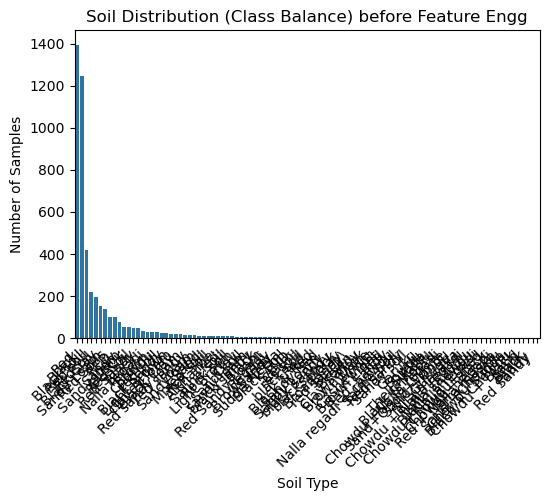

In [35]:
plt.figure(figsize=(6, 4))
soil_counts_orig = orig_df['Soil type'].value_counts()
sns.barplot(x=soil_counts_orig.index, y=soil_counts_orig.values)
plt.title('Soil Distribution (Class Balance) before Feature Engg')
plt.xlabel('Soil Type')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.show()

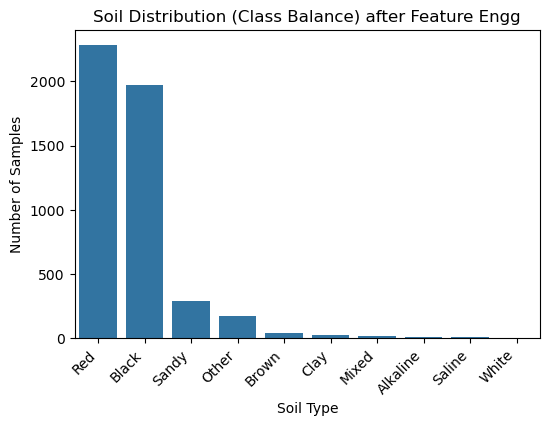

In [36]:
plt.figure(figsize=(6, 4))
soil_counts = df['Soil_Type_Standard'].value_counts()
sns.barplot(x=soil_counts.index, y=soil_counts.values)
plt.title('Soil Distribution (Class Balance) after Feature Engg')
plt.xlabel('Soil Type')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.show()

### 3.2 EDA - Crop Distribution

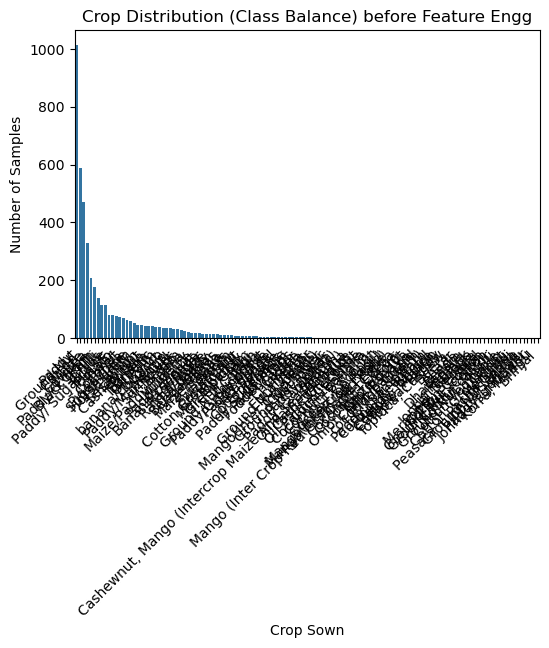

In [37]:
plt.figure(figsize=(6, 4))
soil_counts_orig = orig_df['Crop_Sown'].value_counts()
sns.barplot(x=soil_counts_orig.index, y=soil_counts_orig.values)
plt.title('Crop Distribution (Class Balance) before Feature Engg')
plt.xlabel('Crop Sown')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.show()

In [38]:
# Extract first element from each list
df['First_Crop'] = df['Crop_Sown_Standard'].apply(lambda x: x[0] if isinstance(x, list) and x else None)
df_EDA = df
df.drop(columns=["Crop_Sown_Standard"], inplace=True)

In [39]:
top_25_crops = df['First_Crop'].value_counts().head(25).index.tolist()

# Replace crops not in top 5 with 'others'
df['First_Crop'] = df['First_Crop'].apply(lambda x: x if x in top_25_crops else 'Other')

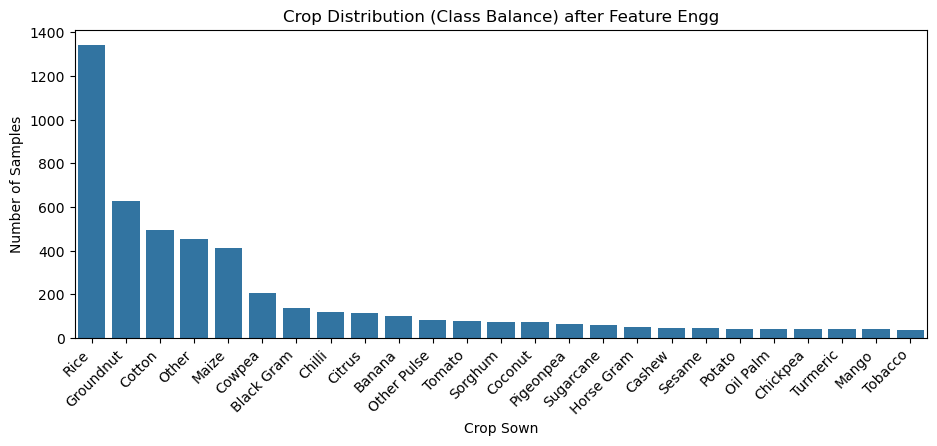

In [40]:
plt.figure(figsize=(11, 4))
crop_counts = df['First_Crop'].value_counts()
sns.barplot(x=crop_counts.index, y=crop_counts.values)
plt.title('Crop Distribution (Class Balance) after Feature Engg')
plt.xlabel('Crop Sown')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.show()

In [41]:
# # Set plotting style
# sns.set(style="whitegrid")

# # ✔ Distribution of Nutrients
# print("\n--- EDA: Distribution of Nutrients ---")
# # Update nutrient_cols to match the columns in df_processed (using hyphens)
# nutrient_cols = ['pH', 'EC', 'OC', 'Avail-P', 'Exch-K', 'Avail-S', 'Avail-Zn', 'Avail-B', 'Avail-Fe', 'Avail-Cu', 'Avail-Mn']

# plt.figure(figsize=(15, 12))
# for i, col in enumerate(nutrient_cols):
#     plt.subplot(4, 3, i + 1) # Adjust subplot layout
#     sns.histplot(df[col], kde=True, bins=20) # Use df_processed instead of data
#     plt.title(f'Distribution of {col}')
# plt.tight_layout()
# plt.show()

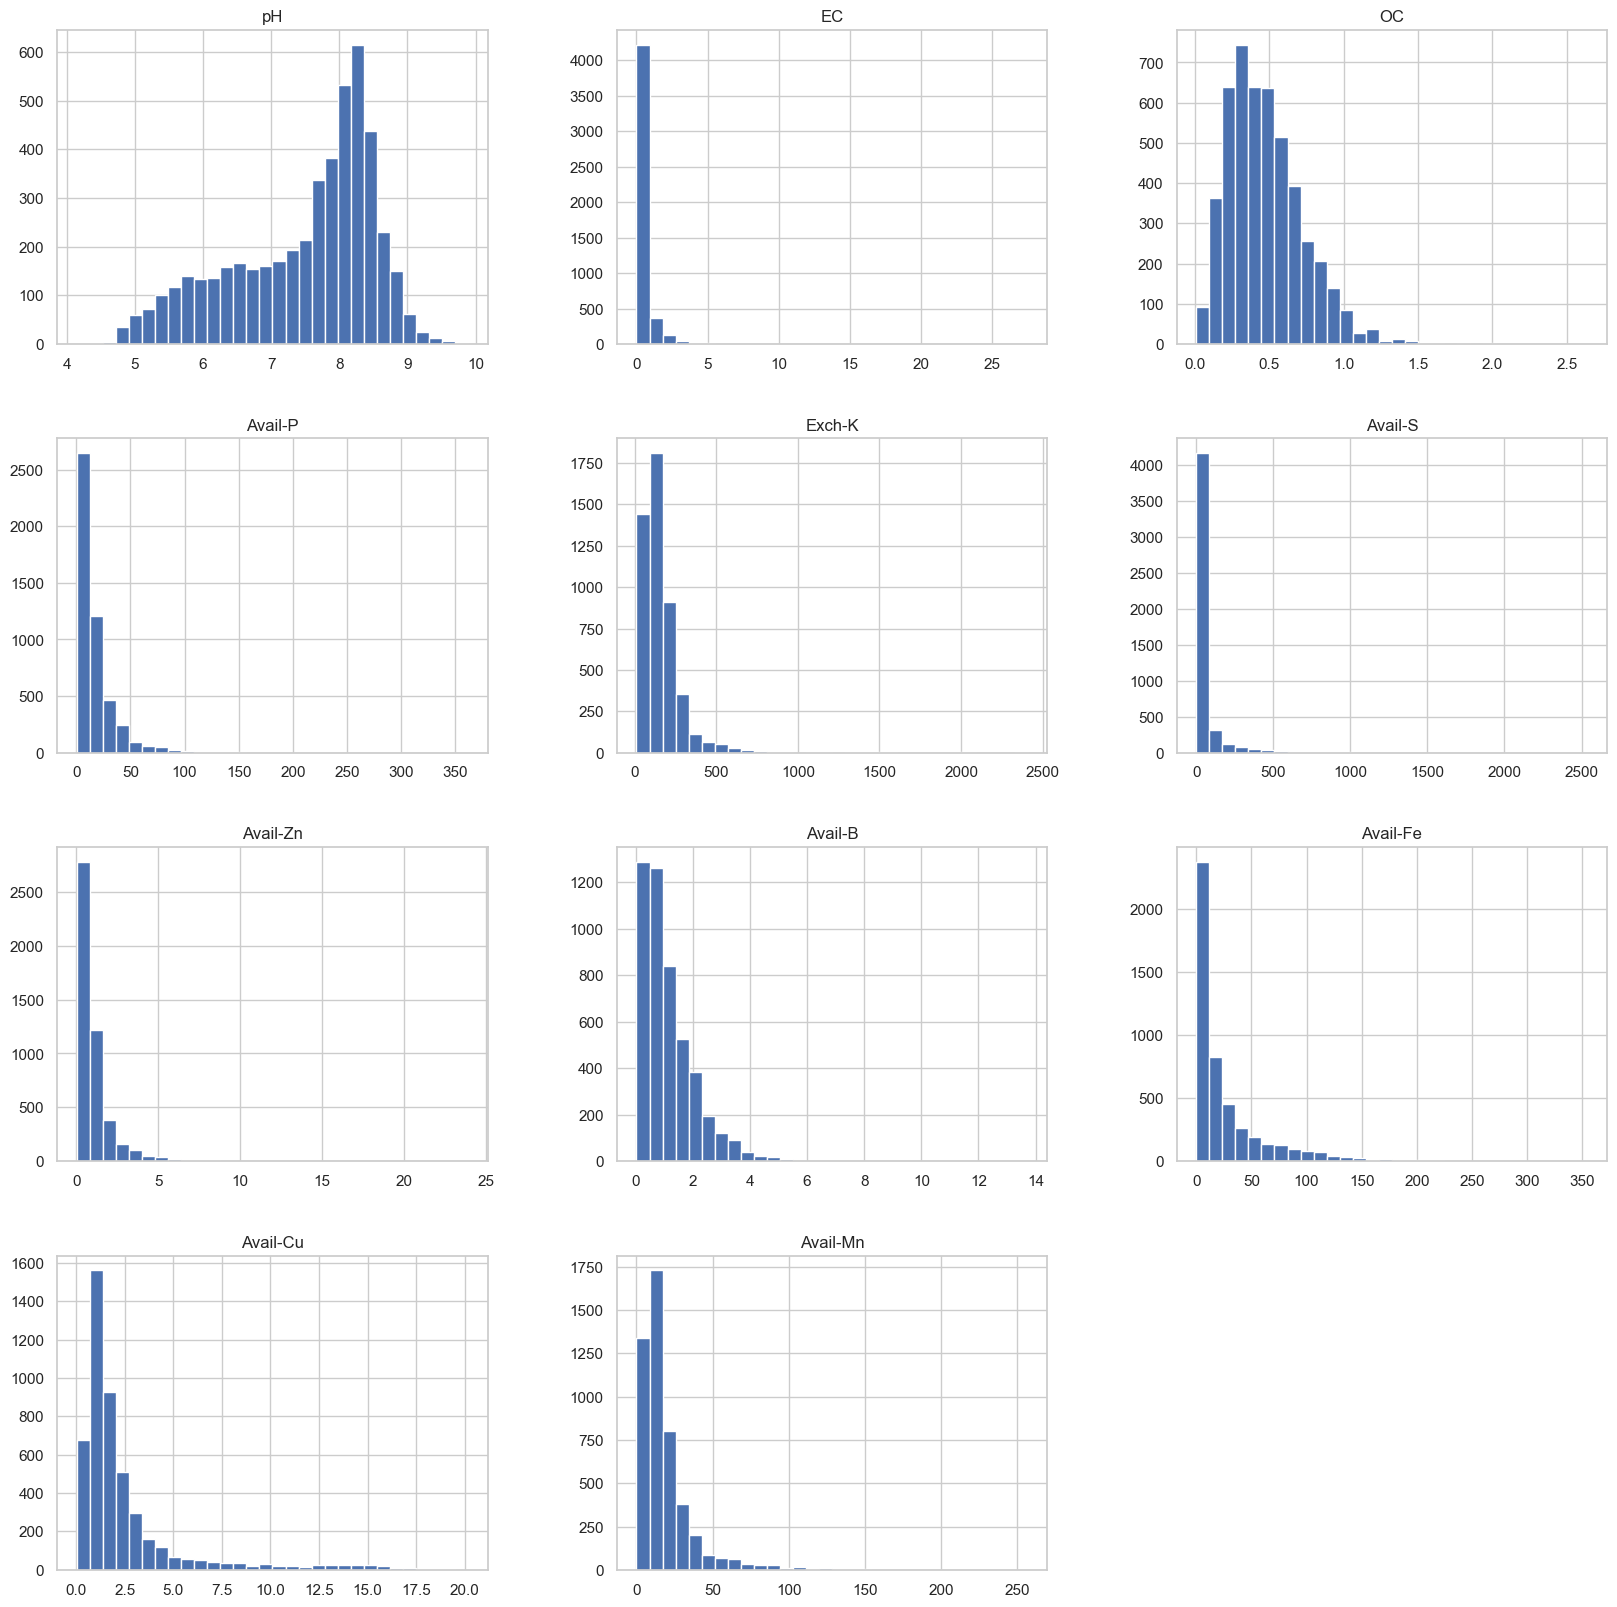

In [42]:
sns.set(style="whitegrid")
nutrient_cols = ['pH', 'EC', 'OC', 'Avail-P', 'Exch-K', 'Avail-S', 'Avail-Zn', 'Avail-B', 'Avail-Fe', 'Avail-Cu', 'Avail-Mn']
df[nutrient_cols].hist(bins=30, figsize =(20,20))
plt.show()

<Axes: >

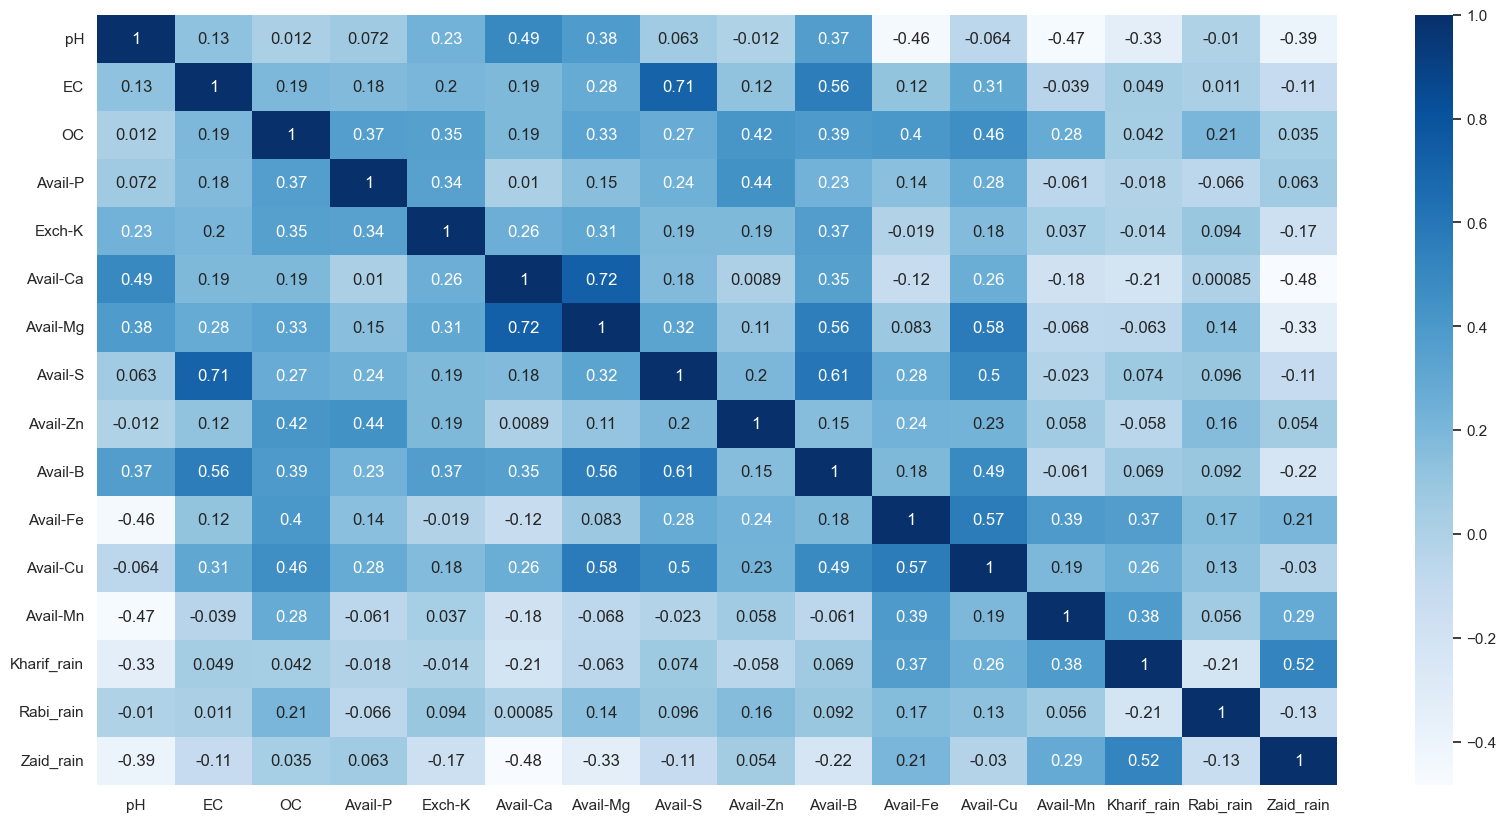

In [43]:
plt.figure(figsize=(20, 10))
sns.heatmap(df[numerical_cols].corr(), cmap="Blues",annot=True)

In [44]:
#Encode 3 categorical variables which need to be converted to numerical format
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()  
df['District_encoded']=le.fit_transform(df['District'])
df['Mandal_encoded']=le.fit_transform(df['Mandal'])
df['Village_encoded']=le.fit_transform(df['Village'])
#df['Soil_Type_Standard_encoded']=le.fit_transform(df['Soil_Type_Standard'])
df['First_Crop_encoded']=le.fit_transform(df['First_Crop'])

In [45]:
# Remove Categorical variables
df_new = df.drop(['District', 'Mandal', 'Village', "Soil_Type_Standard" ,"First_Crop"], axis=1)

In [46]:
#Create numpy arrays for features and target
X = df_new.drop('First_Crop_encoded',axis=1).values
y = df_new['First_Crop_encoded'].values

In [47]:
#Split the dataset into train and test with stratification
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

In [48]:
#Data scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the parameters learned from the training data
X_test_scaled = scaler.transform(X_test)

In [49]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [54]:
#import Gaussian NB Classifier
from sklearn.naive_bayes import GaussianNB

#Setup a gnb classifier
model_nb = GaussianNB()

#Fit the model
# model_nb.fit(X_train_pca, y_train)
# y_pred_nb = model_nb.predict(X_test_pca)

model_nb.fit(X_train_scaled, y_train)
y_pred_nb = model_nb.predict(X_test_scaled)

#Compute accuracy on the training set
# print("Gaussian NB Train Accuracy:",model_nb.score(X_train_scaled, y_train))

# #Compute accuracy on the test set
# print("Gaussian NB Test Accuracy:",model_nb.score(X_test_scaled, y_test))

# 6. Evaluate model
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))

Accuracy: 0.3475103734439834
Classification Report:
               precision    recall  f1-score   support

           0       0.11      0.05      0.07        20
           1       0.00      0.00      0.00        28
           2       0.06      0.22      0.09         9
           3       0.13      0.50      0.21         8
           4       0.46      0.75      0.57        24
           5       0.62      0.91      0.74        23
           6       0.17      0.40      0.24        15
           7       0.53      0.32      0.40        99
           8       0.41      0.93      0.57        41
           9       0.45      0.33      0.38       126
          10       0.12      0.40      0.19        10
          11       0.53      0.12      0.20        82
          12       0.50      0.12      0.20         8
          13       0.32      0.88      0.47         8
          14       0.48      0.11      0.18        90
          15       0.64      1.00      0.78        16
          16       0.10     

In [57]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_pca, y_train)
y_pred_rf = rf.predict(X_test_pca)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_pca, y_train)
y_pred_gb = gb.predict(X_test_pca)
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Gradient Boosting Classification Report:\n", classification_report(y_test, y_pred_gb))

Random Forest Accuracy: 0.3153526970954357
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.12      0.10      0.11        20
           1       0.19      0.18      0.18        28
           2       0.33      0.22      0.27         9
           3       0.09      0.12      0.11         8
           4       0.10      0.08      0.09        24
           5       0.14      0.13      0.14        23
           6       0.10      0.07      0.08        15
           7       0.23      0.22      0.23        99
           8       0.15      0.15      0.15        41
           9       0.36      0.45      0.40       126
          10       0.17      0.10      0.12        10
          11       0.31      0.32      0.32        82
          12       0.00      0.00      0.00         8
          13       0.25      0.12      0.17         8
          14       0.11      0.10      0.11        90
          15       0.29      0.12      0.17        16
